# Lab 11. Neural networks with tensorflow

#### Table of contents

1. Overview
2. Tensorflow
3. Prepare the data
4. Feedforward network with tensorflow

## 1. Overview

In this lab session we will learn a low-level implementation of a 2-layer feedforward neural network with Tensorflow and train it to predict atomization energies based on QM7b dataset.

## 2. Tensorflow

TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications (from tensorflow [website](https://www.tensorflow.org/)).

## 3. Prepare the data

Let's first load the QM7 dataset and reshape it into 2D arrays (this was explained in Lab8). 

In [1]:
from scipy.io import loadmat
qm7 = loadmat('qm7b.mat')

In [2]:
import numpy as np
X0 = qm7['X']
X = X0.reshape(7211,529)
X = np.c_[X]
print(X.shape)

(7211, 529)


In [3]:
y = qm7['T'][:,0]*0.043
y = np.c_[y]
print(y.shape)

(7211, 1)


## 4. Feedforward network with tensorflow

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
# Import tensorflow
# If old version uncomment the line below
import tensorflow as tf
# If newer version uncomment the 2 lies below
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

def fit_net(X, y, net_params):
    
    training_epochs,alpha,lmbda,batch_size,display_step,n_hidden_1,n_hidden_2 = net_params
    
    tf.reset_default_graph()
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=21)
    X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size = 0.5,random_state=22)

    # Scale data
    scaler = MinMaxScaler().fit(X_train)   
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    Y_size, X_size = X_train.shape
    Y_size = 1
    
    # Create tf placeholders i.e. variables that we will assign data later 
    X = tf.placeholder("float", [None, X_size], name='features')
    Y = tf.placeholder("float", [None, 1], name='target')
    
    # Initialize weights & biases
    W1 = tf.Variable(tf.truncated_normal([X_size, n_hidden_1], mean=0, stddev=1 / np.sqrt(X_size)), name='weights1')
    b1 = tf.Variable(tf.zeros([n_hidden_1]), name='biases1')
    
    W2 = tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], mean=0, stddev=1 / np.sqrt(X_size)), name='weights2')
    b2 = tf.Variable(tf.zeros([n_hidden_2]), name='biases2')
    
    W_out = tf.Variable(tf.truncated_normal([n_hidden_2, Y_size], mean=0, stddev=1 / np.sqrt(X_size)), name='weights_out')
    b_out = tf.Variable(tf.zeros([Y_size]), name='biases_out')

    # Create model
    def net(x):
        
        layer_1 = tf.add(tf.matmul(x, W1),b1) 
        layer_1 = tf.nn.tanh(layer_1)
        
        layer_2 = tf.add(tf.matmul(layer_1, W2),b2) 
        layer_2 = tf.nn.tanh(layer_2)
        
        out_layer = tf.add(tf.matmul(layer_2, W_out),b_out) 
    
        return out_layer

    # Define loss & optimizer
    loss = tf.sqrt(tf.losses.mean_squared_error(labels = Y, predictions = net(X)))
#    regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W_out) # L2
    regularizer = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2)) + tf.reduce_sum(tf.abs(W_out)) # L1
#    sumf = tf.abs(tf.reduce_sum(net(X)))
    loss_op = tf.reduce_mean(loss + lmbda*regularizer)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=alpha)
    train_op = optimizer.minimize(loss_op)

    # Initializing the variables
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        
        total_batch = int(X_train.shape[0]/batch_size)

        # Evaluate RMSE on training & validation sets
        rmse = sess.run(loss,feed_dict={X:X_train,Y:y_train})
        rmse_val = sess.run(loss,feed_dict={X:X_val,Y:y_val})
        print("Epoch {:3d} {:.4f} {:.4f} eV".format(0, rmse, rmse_val))
        
        # Training cycle
        for epoch in range(training_epochs):
            avg_rmse = 0.0  
            # Loop over mini-batches
            for i in range(total_batch):
                offset = i*batch_size
                # Perform SGD
                X_feed = X_train[offset:offset+batch_size]
                y_feed = y_train[offset:offset+batch_size]
                _, rmse = sess.run([train_op, loss], feed_dict={X: X_feed,Y: y_feed})
                avg_rmse += rmse
                
            avg_rmse /= total_batch
            rmse_val = sess.run(loss,feed_dict={X:X_val,Y:y_val})

            if (epoch+1) % display_step == 0:
                print("Epoch {:3d} {:.4f} {:.4f} eV".format(epoch+1, avg_rmse, rmse_val))
    
        # Evaluate & predict on test set
        pred_test = sess.run(net(X), feed_dict={X:X_test})
        rmse_test = sess.run(loss,feed_dict={X:X_test,Y:y_test})
        print("Optimization Finished!")
        print("Error on test set: {:.4f} eV".format(rmse_test))
        
        sess.close()
    
    return y_test, pred_test

Let's train the network to predict the atomization energies.

In [8]:
training_epochs,alpha,lmbda,batch_size,display_step,n_hidden_1,n_hidden_2 = 80,1e-2,1e-4,10,10,100,100
net_params = training_epochs,alpha,lmbda,batch_size,display_step,n_hidden_1,n_hidden_2
y_test, y_predict = fit_net(X,y,net_params)

Epoch   0 67.8029 68.1643 eV
Epoch  10 3.1691 3.5417 eV
Epoch  20 2.7002 2.8305 eV
Epoch  30 2.3847 2.5611 eV
Epoch  40 2.1939 2.4685 eV
Epoch  50 2.0723 2.4414 eV
Epoch  60 1.9800 2.4474 eV
Epoch  70 1.9035 2.4714 eV
Epoch  80 1.8430 2.4988 eV
Optimization Finished!
Error on test set: 2.3711 eV


Finally, we plot the predicted energies as a function of the energies in the test set.

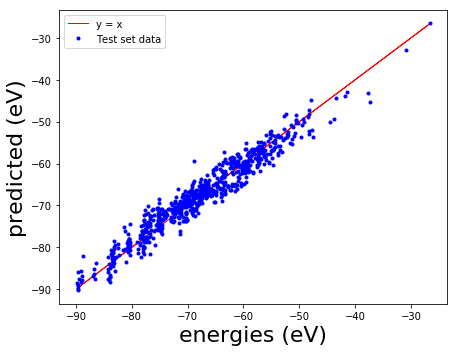

In [10]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)

ax1.plot(y_test,y_test,lw=1,color='r',label="y = x")
ax1.plot(y_test,y_predict,marker='.',color='b',lw=0,label="Test set data")

ax1.set_xlabel('energies (eV)',fontsize=22)
ax1.set_ylabel('predicted (eV)',fontsize=22)
plt.legend()
plt.tight_layout()
plt.show()